Importing Necessary Libraries and Modules

In [ ]:
import my_utils as mu
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.metrics import classification_report

#CIFAR-10 Dataset
CIFAR-10 is a well-known dataset in the field of computer vision and machine learning. It contains 60,000 colour images in 10 classes, with 6,000 images per class. The images are low-resolution, with each image being 32*32 pixels in size. The dataset is split into two parts: The training set contains 50,000 images, and test set contains 10,000 images of ten different classes. 

1.   Basic data augmentation is done such as random crop, horizontal flip.
2.   Image was transformed into tensor and mormalized.
3.   Batch size was set as 128

In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

data_dir = './data'

#Define the data transformations for training and testing
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(),  
                                transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) 
#transforms.RandomRotation(15)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

#Loading the training and testing datasets
train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

batch_size = 128

#Create data loaders for training and testing datasets
train_loader = data.DataLoader (train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = data.DataLoader (test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#Define the classes for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:13<00:00, 12364803.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Sample Image and Label

Label:  truck


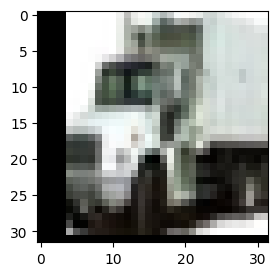

In [ ]:
#Define a function to display an image
def imshow(img):
    npimg = make_grid(img, normalize=True).numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
# Get a batch of training images and display a random image from the batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

sampleImage = random.randint(0, len(images))
print("Label: ",classes[labels[sampleImage]])
imshow(images[sampleImage,:])


#Block Architecture

1. The block includes an MLP layer at the beginning which input the spatial average funtion.
2. MLP layer output channels of MLP is three.
3. Three convolutional layers are made and multiplied with each output channels of MLP after flattening.
4. Output is returned which is the sum of the convolutional layers.

In [ ]:
class cnnBlock(nn.Module):
  def __init__(self,input_channel,output_channels,ks=1,padding=0, strides=1):
     super(cnnBlock,self).__init__()

     #MLP layer
     self.mlp = nn.Sequential(
         nn.Linear(input_channel, 3),
         nn.ReLU(),
         nn.Linear(3, 3), 
         nn.ReLU()
      )
     
     #Convolutionl layers
     self.conv1 = nn.Conv2d(input_channel,output_channels,kernel_size=ks, padding = padding, stride=strides)   
     self.conv2 = nn.Conv2d(input_channel,output_channels,kernel_size=ks, padding = padding, stride=strides)
     self.conv3 = nn.Conv2d(input_channel,output_channels,kernel_size=ks, padding = padding, stride=strides)
     self.relu = nn.ReLU()

  #Define a function for spatial average pooling  
  def spatialAveragePool(self,X): #X.shape = [128,32,32,3]
    X = X.mean(dim=(2,3))
    return X #[250,3]

  def forward(self, x):
    a = self.mlp(self.spatialAveragePool(x))
    out = 0
    # loop which enumerate through conv layers and multiply with each output of MLP layers 
    for i, conv in enumerate([self.conv1, self.conv2, self.conv3]):
        out += a[:, i].view(-1, 1, 1, 1) * self.relu(conv(x))
    return out


#Model Architecture

The CNN model used in this project has the following architecture:

1.   5 Blocks with 64, 128, 256, 512 and 1024 filters respectively, each followed by a batch normalization.  
2.   Maxpooling is added after second, fourth and fifth blocks.
3.   ReLU activation function is used in all layers.
4.   Spatial average pooling is used after the final block.
5.   MLP classifier is used with a dropout regularization with probability 0.5.

In [ ]:
class cnnNet(nn.Module):
  def __init__(self):
        super(cnnNet, self).__init__()
        self.b1 = cnnBlock(3,64,3,1,1)
        self.bn1 = nn.BatchNorm2d(64)
        self.rl1 = nn.ReLU()
        self.b2 = cnnBlock(64,128,3,1,1)
        self.bn2 = nn.BatchNorm2d(128)
        self.rl2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.b3 = cnnBlock(128,256,3,1,1)
        self.bn3 = nn.BatchNorm2d(256)
        self.rl3 = nn.ReLU()
        self.b4 = cnnBlock(256,512,3,1,1)
        self.bn4 = nn.BatchNorm2d(512)
        self.rl4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.b5 = cnnBlock(512,1024,3,1,1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.rl5 = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.spatialAveragePool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=0.5), nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, 10))

  def forward(self,X):
    X = self.b1(X)
    X = self.bn1(X)
    X = self.rl1(X)
    X = self.b2(X)
    X = self.bn2(X)
    X = self.rl2(X)
    X = self.maxpool1(X)
    X = self.b3(X)
    X = self.bn3(X)
    X = self.rl3(X)
    X = self.b4(X)
    X = self.bn4(X)
    X = self.rl4(X)
    X = self.maxpool2(X)
    X = self.b5(X)
    X = self.bn5(X)
    X = self.rl5(X)
    X = self.maxpool(X)
    X = self.spatialAveragePool(X)
    X = X.view(X.size(0),-1)
    out = self.classifier(X)
    return out
      

In [ ]:
#Defining the Training
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0.0, 2.0],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

#Loss and Optimizer
   
1.   The loss function used is Cross entropy loss.
2.   The hyper parameters used where learning rate = 0.001 and weight decay = 0.0001.
3.   Optimizer used is Adam that will be used to update the weights of the neural network during training, which is a popular optimizer for deep learning that combines the benefits of both the RMSProp and AdaGrad optimizers. model.parameters() specifies the learnable parameters of the model that the optimizer should update during training, and lr specifies the learning rate for the optimizer.

In [ ]:
model = cnnNet()
loss = nn.CrossEntropyLoss() #Loss function
lr = 0.001 #Learning Rate
#wd = 0.0001 #Weight Decay
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #Adam Optimizer

#Training the Model

1.   The best available gpu is used using a device method.
2.   The model is trained using Adam  with a learning rate and weight decay. The training is performed for 30 epochs with a batch size of 128. 
3.   Training and testing accuracy is plotted in a graph.
4.   Training function is made using the my_utils file which was provided where the animator function is defined which is creating the graph.

loss 0.127, train acc 0.958, test acc 0.889
550.6 examples/sec on cuda


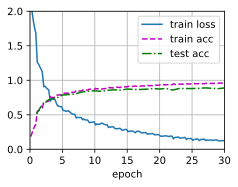

In [ ]:
#Training the model using the best available processor 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu

#Training
num_epochs = 30
trainf(model, train_loader, test_loader, loss, num_epochs, optimizer, device)

#classification report
 The classification report was printed to find how the model performed in each class.

In [ ]:
#Classification Report which show how the model performed based on each class using the f1-score.
all_predictions = []
all_targets = []

# Loop over the test dataset and make predictions for each batch
with torch.no_grad():
    for inputs, targets in test_loader:
        # Move the inputs and targets to the device (e.g. GPU)
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        # Compute the predictions and append them to the list of all predictions
        _, predictions = torch.max(outputs, dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concatenate the lists of predictions and targets to form arrays
all_predictions = np.concatenate(all_predictions)
all_targets = np.concatenate(all_targets)

# Compute the classification report for the predictions
report = classification_report(all_targets, all_predictions, target_names=classes)
print(report)

              precision    recall  f1-score   support

       plane       0.91      0.88      0.89      1000
         car       0.93      0.96      0.94      1000
        bird       0.87      0.80      0.83      1000
         cat       0.77      0.82      0.80      1000
        deer       0.88      0.88      0.88      1000
         dog       0.85      0.84      0.85      1000
        frog       0.92      0.92      0.92      1000
       horse       0.91      0.92      0.91      1000
        ship       0.92      0.94      0.93      1000
       truck       0.94      0.92      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

